## Introduction
This notebook reproduces the sensitivity analysis reported in Noble et al. (2023) 10.26434/chemrxiv-2023-d22xj
<br> Although we have provided ranges for a number of process assumptions, we have shared the original code for producing this figure with the hope that readers will critically evaluate the assumptions and test their own scenarios for ore prices, capital costs, energy efficiency, electricity prices, etc...
<br>Contact pkempler@uoregon.edu with questions or suggestions for the technoeconomic analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IRR=0.08 #annual basis
lifetime=20 #plant lifetime years
installation=1 #fraction, optional
bop=1 #fraction, optional
INFLATION=0.038 #frac, average U.S. inflation rate from 1960 to 2021
prod_TPD=100 # tonne per day

def efficiency_fe(volts, selectivity=1):
    ## calculates efficiency in Wh/g, kWh/kg, MWh/tonne
    eff = volts*3*96485/(3600*55.4)/selectivity
    return eff

In [3]:
print(111000000*1.98/500)

439560.0


In [4]:
def NPV_calc(Iron_Price, Iron_Prod, Cell_Voltage, Electric_Price, CAPACITY=0.98, NaOHCAPACITY=0,Cl2CAPACITY=0.95, FeCAPACITY=0.90,
            electric_price=75, iron_ore_price=120, brine_price=1, hcl_price=150, naoh_price=300, cl2_price=150,
            PLANTFACTOR=1,replace_rate=7):
    
    # Reference for Chlor Alkali Plant Costs
    # https://www3.epa.gov/ttn/ecas/docs/eia_ip/chlorine_eia_08-2000.pdf
    # Chloralkali plant (500 t/d), converted from 1990 dollars to 2020 dollars
    plantcost = 111000000*1.98*PLANTFACTOR #2020 dollars
    employees = 61 # Reference: https://doi.org/10.1016/0921-3449(94)90037-X
    average_salary = 50000 # Assumed salary US Chemical Plant Operator
    annual_labor = average_salary * employees
    cl2_per_tpd = plantcost/500
    tFeptCl2 = 2 / 3 * 55 / 71 # Roughly 50%, so a 50 tpd iron plant produces 100 tpd cl2
    tNaOHptFe = 3*40/55 # Roughly 2.18... 
    tFe2O3ptFe = 1*160/(2*55.4)
    tNaClptFe = (1/0.6)*3*1000/55.4
    
    system_cost = cl2_per_tpd/tFeptCl2*Iron_Prod # $ calculated from fe_tpd sizing
    
    # Other default variables
    # electric_price = 70 #$/MWh
    # iron_ore_price = 120 #$/tonne - https://markets.businessinsider.com/commodities/iron-ore-price
    # brine_price = 1 #$/tonne
    # hcl_price = 150 #$/tonne #https://www.indexbox.io/store/world-hydrogen-chloride-hydrochloric-acid-market-report-analysis-and-forecast-to-2025/
    # naoh_price = 300 #$/tonne #https://www.indexbox.io/blog/caustic-soda-price-per-ton-april-2022/
    # cl2_price = 150 #$/tonne #https://www.indexbox.io/blog/chlorine-price-per-ton-april-2022/
        
    #Assumption for stack replacement costs ~20% of system cost
    stack_cost = 0.20*system_cost
    production = Iron_Prod*1000/24 # production rate (kg/h) from tpd
    
    #Keep voltage drift = 0 for now
    voltage_drift = 0
    
    #Calculate Stack Eff
    stackeff = efficiency_fe(Cell_Voltage) # MWh/tonne
    
    #Timeline
    max_year = 20 #years
    
    #Scheduled cash flow
    CashFlow = pd.DataFrame({'Years':[],'Stack Life':[],'Inflation Year':[],
                            'Stack Eff (MWh/t)':[], 'Sales':[],'Replacement Costs':[],'Operating Costs':[],
                            'Net Cash Flow':[],'Discounted Flow':[]})
    
    ## Initialize variables
    year = [1]
    stacklife = [0]
    inflationyear = [1]
    sales = [0]
    replacement_costs = [0]
    operating_costs = [0]
    net_cash = [-system_cost]
    discounted_cash = [net_cash[-1]/(1+IRR)**year[-1]]

    for x in range(2,max_year+2):
        year.append(x)
        inflationyear.append((1+INFLATION)**x)

        #Iron, Chlorine, NaOH sales
        iron_sale = Iron_Price/1000*production*8760*CAPACITY*FeCAPACITY
        cl2_sale = cl2_price/1000*production/tFeptCl2*8760*CAPACITY*Cl2CAPACITY
        naoh_sale = cl2_price/1000*production*tNaOHptFe*8760*CAPACITY*NaOHCAPACITY
        
        sales.append(iron_sale+cl2_sale+naoh_sale) # [$/kg] * [kg/h] * [h/year] * percent
        sales[-1] = sales[-1]*inflationyear[-1]

        #Stacklife counting
        if stacklife[-1] < replace_rate and year[-1] != max_year: # Don't replace stack in the last year of life
            stacklife.append(stacklife[-1]+1)
        else:
            stacklife.append(1)

        #Maintenance cost are 0.5% system cost per year + stack replacement
        replacement_costs.append(stack_cost*(stacklife[-1]==replace_rate) + 0.005*system_cost)
        replacement_costs[-1] = replacement_costs[-1]*inflationyear[-1]

        #Operating costs are assumed to be dominated by electricity prices and ore prices
        r_prod = production*8760*CAPACITY
        e_expense = Electric_Price/1000*stackeff*r_prod
        w_expense = brine_price/1000*r_prod*tNaClptFe
        fe2o3_expense = iron_ore_price/1000*r_prod*tFe2O3ptFe
        expenses = e_expense+w_expense+fe2o3_expense+annual_labor
        #[$/kWh] * [kWh/kg] * [kg/h] * [h/year] * percent
        operating_costs.append(expenses)
        operating_costs[-1] = operating_costs[-1]*inflationyear[-1]

        #Net cash flow = Sales - replacement - operating costs
        net_cash.append(sales[-1] - operating_costs[-1] - replacement_costs[-1])

        #Discounted cash flow = net cash flow / (1+IRR)^year
        discounted_cash.append(net_cash[-1]/(1+IRR)**year[-1])

    CashFlow['Years'] = year
    CashFlow['Stack Life'] = stacklife
    CashFlow['Inflation Year'] = inflationyear
    CashFlow['Stack Eff (MWh/t)'] = stackeff
    CashFlow['Sales'] = sales
    CashFlow['Replacement Costs'] = replacement_costs
    CashFlow['Operating Costs'] = operating_costs
    CashFlow['Net Cash Flow'] = net_cash
    CashFlow['Discounted Flow'] = discounted_cash

    return sum(CashFlow['Discounted Flow']), CashFlow

In [5]:
def LCOFe(CV=3.2,EP=75,FeCap=0.90,NaCap=0,Cl2Cap=0.95,plantfac=1,replace=7, ore=120, plantcap=0.98):
    # System function
    low_price = 1
    high_price = 1000
    
    # Measure slope of NPV calculator
    low_val, low_table = NPV_calc(Iron_Price=low_price, Iron_Prod=prod_TPD, 
                                  Cell_Voltage=CV, Electric_Price=EP, 
                                  CAPACITY=plantcap, FeCAPACITY=FeCap, 
                                  NaOHCAPACITY=NaCap, iron_ore_price=ore,
                                 PLANTFACTOR=plantfac,Cl2CAPACITY=Cl2Cap,
                                 replace_rate=replace)
    
    high_val, high_table = NPV_calc(Iron_Price=high_price, Iron_Prod=prod_TPD, 
                                    Cell_Voltage=3.2, Electric_Price=30,
                                    CAPACITY=plantcap, FeCAPACITY=FeCap,
                                    NaOHCAPACITY=NaCap, iron_ore_price=ore,
                                     PLANTFACTOR=plantfac,Cl2CAPACITY=Cl2Cap,
                                     replace_rate=replace);
    
    # Interpolate to solve for exact LCOX
    slope = (high_price - low_price)/(high_val - low_val)

    return high_price - high_val*slope

### Range of values for electricity prices

In [6]:
lowE = LCOFe(EP=25) # $/MWh
baseE = LCOFe(EP=75)
highE = LCOFe(EP=150)

print('Low = {}, Med = {}, High = {}'.format(lowE,baseE,highE))

Low = 475.66210489472655, Med = 585.5434315641066, High = 684.6663751014014


### Range of values for plant capital expense

In [7]:
lowplant = LCOFe(plantfac=0.5)
baseplant = LCOFe(plantfac=1)
highplant = LCOFe(plantfac=2)

print('Low = {}, Med = {}, High = {}'.format(lowplant,baseplant,highplant))

Low = 482.72971261651594, Med = 585.5434315641066, High = 791.170869459288


### Range of values for chlorine capacity factor

In [8]:
lowCl2 = LCOFe(Cl2Cap=0.5)
noCl2 = LCOFe(Cl2Cap=0)
base = LCOFe(Cl2Cap=0.95)

print('Low = {}, Med = {}, High = {}'.format(base,lowCl2,noCl2))

Low = 585.5434315641066, Med = 703.379991183794, High = 834.3095018723355


### Range of values for iron capacity factor

In [9]:
loweta = LCOFe(FeCap=0.4)
med1eta = LCOFe(FeCap=0.7)
med2eta = LCOFe(FeCap=0.9)
higheta = LCOFe(FeCap=0.99)

print('Low = {}, Med1 = {}, Med2 = {}, High = {}'.format(loweta,med1eta,med2eta,higheta))

Low = 1066.1257746053248, Med1 = 714.3472492652761, Med2 = 585.5434315641066, High = 541.5984501163609


### Range of values for cell voltage

In [10]:
lowCV = LCOFe(CV=2.2) # volts
baseCV = LCOFe(CV=3.2)
highCV = LCOFe(CV=4.2)

print('Low = {}, Med = {}, High = {}'.format(lowCV,baseCV,highCV))

Low = 540.3954604709155, Med = 585.5434315641066, High = 622.6148136322379


In [11]:
LCOFe(EP=0,plantcap=0.78)

501.17805027086575

In [12]:
print(LCOFe(FeCap=0.75,ore=70), LCOFe(FeCap=0.95,ore=140))

601.8375478886708 585.2015539979477


### Range of values for replacement rate of the stack components

In [13]:
lowrep = LCOFe(replace=14) # years
baserep = LCOFe(replace=7)
highrep = LCOFe(replace=3)

print('Low = {}, Med = {}, High = {}'.format(lowrep,baserep,highrep))

Low = 561.5292739373623, Med = 585.5434315641066, High = 671.350616703129


### Range of values for the ore price

In [14]:
lowore = LCOFe(ore=80) # $/tonne
medore = LCOFe(ore=120)
highore = LCOFe(ore=240)

# According to business insider, these represent the 2 year low, present cost, and 2 year high, respectively

print('Low = {}, Med = {}, High = {}'.format(lowore,medore,highore))

Low = 533.4683958162757, Med = 585.5434315641066, High = 741.7685388075995


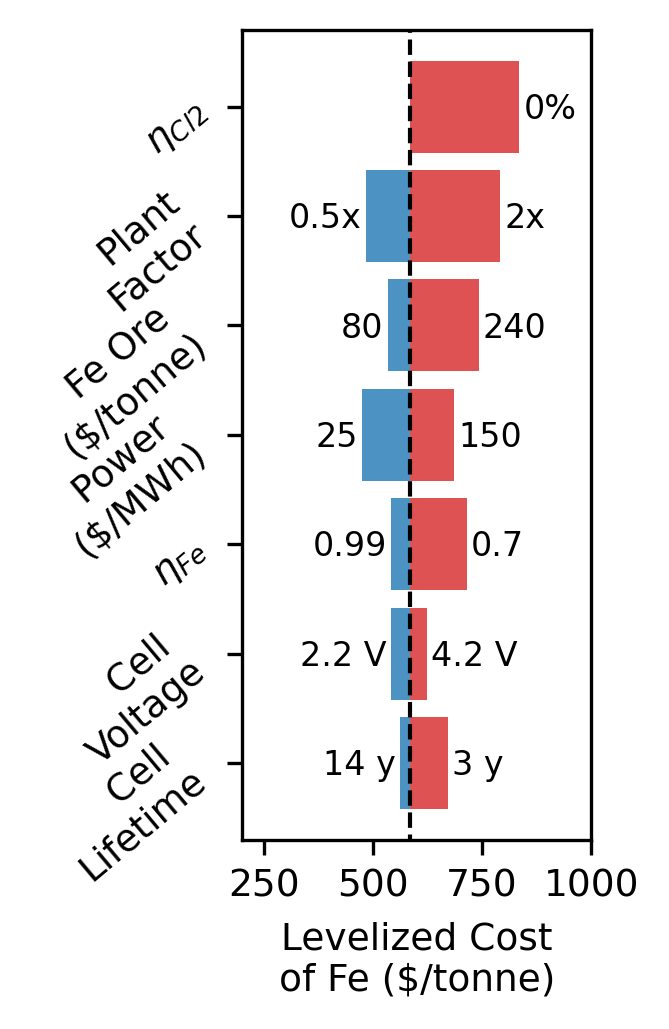

In [15]:
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 9}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(2.3,3.5))

labels = ['Cell \nLifetime','Cell \nVoltage', '$\eta_{Fe}$',
          'Power \n($/MWh)', 'Fe Ore \n($/tonne)', 
          'Plant\nFactor', '$\eta_{Cl2}$']

compression=1.4
xs = [(x+1)/compression for x in range(0,len(labels))]

highs = [highrep,highCV,med1eta,highE,highore,highplant,noCl2]
meds = [baserep,baseCV,med2eta,baseE,medore,baseplant,base]
lows = [lowrep,lowCV,higheta,lowE,lowore,lowplant,baseplant]

highlabels=['3 y','4.2 V','0.7','150','240','2x','0%']
lowlabels=['14 y','2.2 V','0.99','25','80','0.5x','']

AVAL = 0.8
heights = 0.6

for pos, x in enumerate(xs):   
    plt.broken_barh([(baseplant,highs[pos]-baseplant),(lows[pos],baseplant-lows[pos])],
                    (x-heights/2,heights),facecolors=('tab:red', 'tab:blue'),alpha=AVAL)
    plt.text(highs[pos]+10,x-0.08,highlabels[pos],size=8)
    plt.text(lows[pos]-10,x-0.08,lowlabels[pos],horizontalalignment='right',size=8)
         
plt.plot([base, base],[0, 10],'k--',linewidth=1)
    
ax.set_yticks(xs)
ax.set_xticks([250,500,750,1000])
ax.set_yticklabels(labels,rotation=40)
ax.set_xlabel('Levelized Cost\nof Fe ($/tonne)')

ax.set_ylim([xs[0]-0.5,xs[-1]+0.5])
ax.set_xlim([200,1000])

plt.gcf().set_dpi(300)
fig.tight_layout()

In [16]:
#fig.savefig('Figure 3E.png', transparent=True)

### Generate plot of of Levelized Cost of Fe for various electricity prices and plant capacity factors

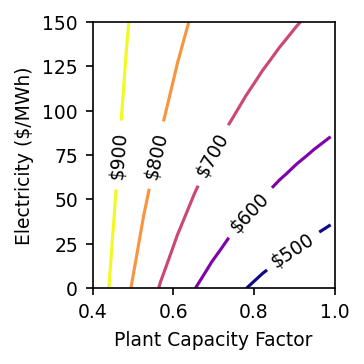

In [17]:
# Set up a mesh grid for desired variables
EPs = np.linspace(0,150,15)
PlantCaps = np.linspace(0.4,0.99,15)
XX,YY = np.meshgrid(EPs,PlantCaps) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

for row in range(0,len(PlantCaps)):
    for col in range(0,len(EPs)):
            p_elec = XX[row,col]
            Cap = YY[row,col]
            Z[row,col] = LCOFe(EP=p_elec, plantcap=Cap)
            
fig, ax = plt.subplots(figsize=(2,2))

CS = ax.contour(YY, XX, Z, [500,600,700,800,900], cmap='plasma')
ax.set_ylabel('Electricity ($/MWh)')
plt.xlabel('Plant Capacity Factor')
ax.set_xticks([0.4,0.6,0.8,1.0])
ax.clabel(CS, inline=True, fontsize=9, colors='k', fmt='$%1.0f')
plt.gcf().set_dpi(150)

fig.set_size_inches(2.5, 2.5)
fig.tight_layout()

### Generate a plot of Levelized Cost of Fe for various ore prices and Fe selectivity 

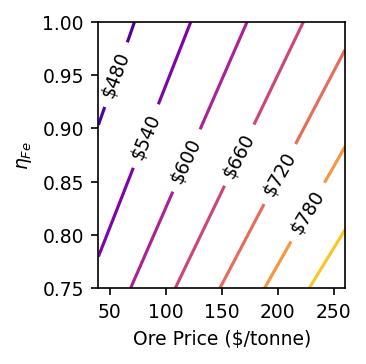

In [18]:
## Set up a mesh grid for desired variables
ores = np.linspace(40,260,15)
Etas = np.linspace(0.75,1.0,15)
XX,YY = np.meshgrid(ores,Etas) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

#Run models
for row in range(0,len(Etas)):
    for col in range(0,len(ores)):
            p_ore = XX[row,col]
            Eta = YY[row,col]
            Z[row,col] = LCOFe(ore=p_ore, FeCap=Eta)
            
fig, ax = plt.subplots(figsize=(2,2))

#Plot data
CS = ax.contour(XX, YY, Z, cmap='plasma')
ax.set_xlabel('Ore Price ($/tonne)')
ax.set_xticks([50,100,150,200,250])
plt.ylabel('$\eta_{Fe}$')
ax.clabel(CS, inline=True, fontsize=9, colors='k', fmt='$%1.0f')
plt.gcf().set_dpi(150)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()